In [ ]:
!pip install PyTDC rdkit==2023.03.1 DeepChem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')
data.get_data().head(2)

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.22
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.86


In [ ]:
data

In [ ]:
drugs = data.get_data()
drugs

,Drug_ID,Drug,Y
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000
3,creatinine,CN1CC(=O)NC1=N,-5.935409
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000
...,...,...,...
905,Capric acid (decanoic acid),CCCCCCCCCC(=O)O,-4.680000
906,Apometzgerin (2),COc1cc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc(O)c1OC,-4.950000
907,3,COC(=O)C[C@@H](C(=O)NN(Cc1ccc(/C=C\c2ccccc2)cc...,-5.080000
908,51d,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,-5.300000


In [ ]:
import rdkit
rdkit.__version__

'2023.03.1'

In [ ]:
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools, Descriptors, AllChem, AddHs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
import deepchem as dc

In [ ]:
# Let's add the structures to the dataframe
PandasTools.AddMoleculeColumnToFrame(drugs, 'Drug', 'Molecule')

In [ ]:
drugs.sample(5)

,Drug_ID,Drug,Y,Molecule
14,EF5248,CCCCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OCc4o...,-4.350000,<rdkit.Chem.rdchem.Mol object at 0x7fdce6555fc0>
841,S-nitrosylated captopril (CapNO),C[C@H](CSN=O)C(=O)N1CCC[C@@H]1C(=O)O,-4.500000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e8dd90>
506,PoA 22-methyl ether (18),CO[C@H](CCC(C)C)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=...,-4.580000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5ea09e0>
848,21b,CC1CN(CCCNC(=O)[C@@H](Cc2ccccc2)NC(=O)C2(NC(=O...,-5.959303,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e8e0a0>
725,Trimethobenzamide,COc1cc(C(=O)NCc2ccc(OCCN(C)C)cc2)cc(OC)c1OC,-4.960000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e6ea40>


In [ ]:
# There are no hydrogens in these structures. 
for idx, mol in enumerate(drugs.Molecule):
  drugs.Molecule[idx] = rdkit.Chem.AddHs(mol)

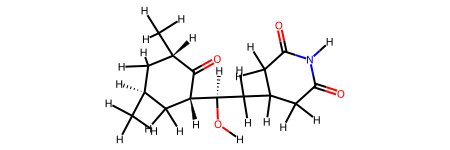

In [ ]:
drugs.Molecule.iloc[-1]

In [ ]:
# Lipinski's rule of 5:
# Poor absorption is likely if the molecule violates more than one of the following conditions:
# Molecular Weight <= 500 Da
# No. Hydrogen Bond Donors <= 10
# No. Hydrogen Bond Acceptors <= 5
# LogP <= 5

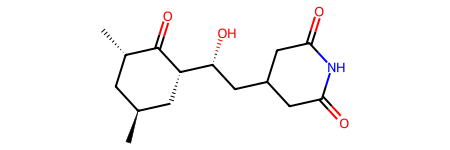

In [ ]:
mol

In [ ]:
def ro5_check(mol):
  MW = Descriptors.MolWt(mol)
  HBA = Descriptors.NOCount(mol)
  HBD = Descriptors.NHOHCount(mol)
  LogP = Descriptors.MolLogP(mol)
  conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
  pass_ro5 = conditions.count(True) >= 3
  return pass_ro5

In [ ]:
# Let's make a new category to sort out all the drugs that violate the ro5
# If it follows ro5, the category = 1 else 0

In [ ]:
drugs['ro5'] = 0
for idx, mol in enumerate(drugs.Molecule):
  if ro5_check(mol) == True:
    drugs.ro5[idx] = 1 

In [ ]:
drugs.sample(20)

,Drug_ID,Drug,Y,Molecule,ro5
468,"5,7,4'-TMF",COc1ccc(-c2cc(=O)c3c(OC)cc(OC)cc3o2)cc1,-4.559546,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e53840>,1
84,isoquercitrin,O=c1c(OC2C(O)OC(CO)C(O)C2O)c(-c2ccc(O)c(O)c2)o...,-6.170000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5ed8f20>,0
685,13i,CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4CCc4ccc(CC(=O)O...,-5.590000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e6d850>,1
18,EF5264,CC(=O)OC(C)OC(=O)N1CCC(N2CCN(CC(=O)c3ccc(OCC(=...,-4.510000,<rdkit.Chem.rdchem.Mol object at 0x7fdce65563b0>,0
891,5'-L-Asp-FUdR,NC(CC(=O)O)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[n...,-6.490000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e8f300>,1
694,T2007,O=C1NC(=O)C(c2ccccc2)(c2ccccc2)C(=O)N1,-4.460000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e6dc40>,1
184,2e,C[C@@H](NC(=O)C1(NC(=O)C(F)(F)F)CC1)c1ccc(-c2c...,-4.552842,<rdkit.Chem.rdchem.Mol object at 0x7fdce5edbae0>,1
106,neolignan smi02,C/C=C/c1cc(OC)c2c(c1)C(C)C(c1cc(OC)c(O)c(OC)c1)O2,-5.340000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5ed98c0>,1
870,21,Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2...,-5.000000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e8e9d0>,1
719,Levofloxacin,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,-4.550000,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e6e730>,1


In [ ]:
# Let's look at the descriptors
des_keys = Descriptors.CalcMolDescriptors(drugs.Molecule[0]).keys()

In [ ]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [ ]:
type(des_keys)

dict_keys

In [ ]:
des = Descriptors.CalcMolDescriptors(drugs.Molecule[0])

In [ ]:
len(des)

209

In [ ]:
# Problem! It is difficult to calculate descriptors directly for the dataframe.
# Let's us use DeepChem

In [ ]:
rdkit_featurizer = dc.feat.RDKitDescriptors()

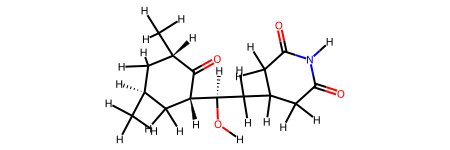

In [ ]:
mol

In [ ]:
rdkit_featurizer.featurize(mol)

array([[ 1.38516320e+01,  1.38516320e+01,  9.73220698e-01,
        -5.20893802e+00,  7.57155600e-01,  2.81352000e+02,
         2.58168000e+02,  2.81162708e+02,  1.12000000e+02,
         0.00000000e+00,  2.26338055e-01, -3.92368254e-01,
         3.92368254e-01,  2.26338055e-01,  1.55000000e+00,
         2.30000000e+00,  2.90000000e+00, -1.72683971e-16,
        -2.46769264e-01, -5.50314207e-17, -2.80808164e+00,
        -1.57050774e-16, -2.81461525e+00,  5.58036532e-18,
        -1.13431736e+00,  2.84389418e+00,  3.31501334e+00,
         1.21392725e+03,  3.50165079e+01,  3.25802068e+01,
         9.58020676e+00,  1.84414285e+01,  1.63691721e+01,
         5.01371018e+00,  3.50535682e+00,  3.50535682e+00,
         2.08667322e+00,  2.08667322e+00,  1.31143743e+00,
         1.31143743e+00, -1.23000000e+00,  2.84389418e+00,
         3.24011651e+00,  6.03773196e+00,  3.44974559e+00,
         1.51124489e+02,  5.10880819e+00,  5.78324495e+00,
         1.41184208e+00,  1.32455591e+01,  0.00000000e+0

In [ ]:
type(rdkit_featurizer.featurize(mol))

numpy.ndarray

In [ ]:
# Separate the descriptors into columns
for idx, mol in enumerate(drugs.Molecule):
  all_des = Descriptors.CalcMolDescriptors(mol)
  for des in des_keys:
    drugs.loc[idx,des] = all_des[des]

drugs.sample(1)

,Drug_ID,Drug,Y,Molecule,ro5,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
395,Cyclo(-PFMewMeKTF-) (6),C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)N(C)C(=O)[C...,-6.742364,<rdkit.Chem.rdchem.Mol object at 0x7fdce5e51850>,0,17.236212,17.236212,0.724834,-7.023172,0.122601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = drugs
X.head(1)

,Drug_ID,Drug,Y,Molecule,ro5,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.22,<rdkit.Chem.rdchem.Mol object at 0x7fdce6555930>,1,8.85697,8.85697,0.890041,-3.607962,0.509593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = X.drop(columns=['Drug_ID','Drug','Molecule'])
X.head(1)

,Y,ro5,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-6.22,1,8.85697,8.85697,0.890041,-3.607962,0.509593,290.271,276.159,290.079038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_fea = X.iloc[:,2:]

In [ ]:
X_fea.head(1)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.85697,8.85697,0.890041,-3.607962,0.509593,290.271,276.159,290.079038,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X['ro5']

0      1
1      1
2      1
3      1
4      1
      ..
905    1
906    1
907    0
908    0
909    1
Name: ro5, Length: 910, dtype: int64

In [ ]:
y = X['Y'] # This is Caco2 permeability
y.head()

0   -6.220000
1   -3.860000
2   -4.090000
3   -5.935409
4   -4.840000
Name: Y, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fea, y,  
                                   random_state=414,
                                   shuffle=True,
                                   test_size=.2)
print(y_train.value_counts())
print(y_test.value_counts())

-5.820000    20
-5.300000    12
-4.510000     8
-5.700000     7
-5.000000     7
             ..
-4.449099     1
-5.090000     1
-7.390000     1
-5.935409     1
-5.597583     1
Name: Y, Length: 500, dtype: int64
-5.820000    6
-5.300000    5
-4.740000    3
-5.690000    2
-4.508638    2
            ..
-5.187451    1
-7.179571    1
-5.739719    1
-4.950000    1
-4.880000    1
Name: Y, Length: 157, dtype: int64


In [ ]:
X_train.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
551,14.331780,14.331780,1.027819,-4.457490,0.275988,448.380,428.220,448.100561,170.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,11.703233,11.703233,0.792811,-4.617064,0.703894,388.895,363.695,388.155370,144.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492,15.059801,15.059801,0.273760,-6.540957,0.355867,534.590,508.382,534.146072,196.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
706,16.211838,16.211838,1.101428,-6.431418,0.111441,705.691,656.299,704.278462,254.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,13.809505,13.809505,0.464390,-4.341167,0.830623,387.440,362.240,387.190654,150.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
848,15.658348,15.658348,0.191804,-5.676791,0.254614,589.806,546.462,589.308661,224.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
413,16.134254,16.134254,0.506755,-6.180133,0.732908,401.485,381.325,401.087926,142.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,12.890005,12.890005,0.749360,-4.335454,0.746755,306.406,280.198,306.194343,122.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,16.257050,16.257050,1.187931,-6.111133,0.439507,501.864,481.704,501.107847,182.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339,13.845410,13.845410,0.234264,-5.057938,0.772957,354.450,328.242,354.194343,138.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.head()

551   -6.100000
250   -5.500000
492   -5.851936
706   -5.320000
135   -4.610000
Name: Y, dtype: float64

In [ ]:
y_test.head()

848   -5.959303
413   -5.888028
370   -4.590000
180   -4.552842
339   -4.810000
Name: Y, dtype: float64

In [ ]:
len(X_train)

728

In [ ]:
X_train[X_train.isnull().any(axis=1)]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
91,13.151090,13.151090,0.0,-3.578285,0.366873,295.270,281.158,295.082052,104.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,11.559838,11.559838,0.0,-3.656906,0.638394,252.245,239.141,252.076239,88.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train = X_train.drop(91)
X_train = X_train.drop(102)

In [ ]:
len(X_train)

726

In [ ]:
for des in des_keys:
  print(X_train[des].isna().value_counts())

False    726
Name: MaxAbsEStateIndex, dtype: int64
False    726
Name: MaxEStateIndex, dtype: int64
False    726
Name: MinAbsEStateIndex, dtype: int64
False    726
Name: MinEStateIndex, dtype: int64
False    726
Name: qed, dtype: int64
False    726
Name: MolWt, dtype: int64
False    726
Name: HeavyAtomMolWt, dtype: int64
False    726
Name: ExactMolWt, dtype: int64
False    726
Name: NumValenceElectrons, dtype: int64
False    726
Name: NumRadicalElectrons, dtype: int64
False    726
Name: MaxPartialCharge, dtype: int64
False    726
Name: MinPartialCharge, dtype: int64
False    726
Name: MaxAbsPartialCharge, dtype: int64
False    726
Name: MinAbsPartialCharge, dtype: int64
False    726
Name: FpDensityMorgan1, dtype: int64
False    726
Name: FpDensityMorgan2, dtype: int64
False    726
Name: FpDensityMorgan3, dtype: int64
False    726
Name: BCUT2D_MWHI, dtype: int64
False    726
Name: BCUT2D_MWLOW, dtype: int64
False    726
Name: BCUT2D_CHGHI, dtype: int64
False    726
Name: BCUT2D_CHGLO, dt

In [ ]:
# Let's do the same for y_train, X_test, and y_test

In [ ]:
# y_train
y_train = y_train.drop(91)
y_train = y_train.drop(102)
print(len(y_train))

726


In [ ]:
# Now for the test set:
X_test[X_test.isnull().any(axis=1)]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [ ]:
# Remove entry 102! 
#print(len(X_test))
#X_test = X_test.drop(102)
#y_test = y_test.drop(102)
print(len(y_test))

182


In [ ]:
for des in des_keys:
  print(X_test[des].isna().value_counts())

False    182
Name: MaxAbsEStateIndex, dtype: int64
False    182
Name: MaxEStateIndex, dtype: int64
False    182
Name: MinAbsEStateIndex, dtype: int64
False    182
Name: MinEStateIndex, dtype: int64
False    182
Name: qed, dtype: int64
False    182
Name: MolWt, dtype: int64
False    182
Name: HeavyAtomMolWt, dtype: int64
False    182
Name: ExactMolWt, dtype: int64
False    182
Name: NumValenceElectrons, dtype: int64
False    182
Name: NumRadicalElectrons, dtype: int64
False    182
Name: MaxPartialCharge, dtype: int64
False    182
Name: MinPartialCharge, dtype: int64
False    182
Name: MaxAbsPartialCharge, dtype: int64
False    182
Name: MinAbsPartialCharge, dtype: int64
False    182
Name: FpDensityMorgan1, dtype: int64
False    182
Name: FpDensityMorgan2, dtype: int64
False    182
Name: FpDensityMorgan3, dtype: int64
False    182
Name: BCUT2D_MWHI, dtype: int64
False    182
Name: BCUT2D_MWLOW, dtype: int64
False    182
Name: BCUT2D_CHGHI, dtype: int64
False    182
Name: BCUT2D_CHGLO, dt

In [ ]:
# Now there should be no NAN values in the DataFrame 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
X_test

array([[ 0.9585839 ,  0.9585839 , -0.89337063, ...,  5.94138031,
         0.        , -0.21821789],
       [ 1.15790818,  1.15790818, -0.44926605, ..., -0.16831106,
         0.        , -0.21821789],
       [-0.20088326, -0.20088326, -0.10717274, ..., -0.16831106,
         0.        , -0.21821789],
       ...,
       [ 0.52733438,  0.52733438,  0.86074263, ..., -0.16831106,
         0.        , -0.21821789],
       [-0.2847333 , -0.2847333 , -0.84734157, ..., -0.16831106,
         0.        , -0.21821789],
       [ 0.11678077,  0.11678077, -0.40126573, ..., -0.16831106,
         0.        ,  4.58257569]])

In [ ]:
lr = LinearRegression(copy_X=True,
                      fit_intercept=False) # The intercept is not fit. So the predictions will be off! 

In [ ]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [ ]:
lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [ ]:
lr_preds = lr.predict(X_test)

In [ ]:
lr_preds

array([-0.04678339,  0.1192145 ,  0.88418073,  0.65991812, -0.16983062,
        0.32318086,  0.48349732,  0.11770982, -1.53300638,  0.40914755,
        0.82655209, -0.28322345,  1.04391317, -0.01041537, -0.13317613,
       -0.64755374,  0.59091061,  0.40601607,  0.63990659, -0.03452505,
        0.47058457,  0.32718496, -0.42754108, -0.05913001, -1.79409438,
        0.24613372, -0.15170032,  0.13515729, -0.23807651, -0.11919147,
       -0.59033328, -0.51935321,  0.0989787 , -0.0123685 ,  1.01272458,
       -0.30099136,  0.62733667,  0.73592156, -1.18218393, -0.37153605,
        0.50163858,  0.73944348, -0.16983062, -1.16705047,  0.31870028,
        1.28441781, -0.87993079,  0.74408978, -0.17341737, -1.03255585,
        0.25020379,  0.5017907 , -0.18905132, -1.76451902, -0.48817727,
       -1.61668998,  0.15957616,  0.62363213, -1.66490012,  0.62683992,
       -1.29865009,  0.68425244, -0.06679565, -0.45894404,  0.22772473,
       -0.16380435, -0.57960966, -0.04651423, -0.10416537, -0.81

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, lr_preds)

In [ ]:
mse

27.848594548141712

In [ ]:
# MSE on the training set:
mse_train = mean_squared_error(y_train, lr.predict(X_train))
mse_train

27.53167186533763

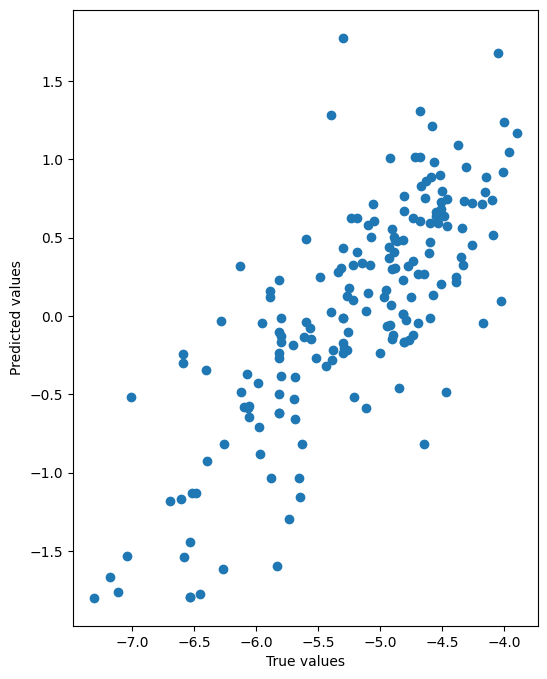

In [ ]:
plt.figure(figsize=(6,8))
plt.scatter(y_test, lr_preds)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

In [ ]:
lr2 = LinearRegression(copy_X=True,
                       fit_intercept=True)

In [ ]:
lr2.fit(X_train, y_train)

LinearRegression()

In [ ]:
preds2 = lr2.predict(X_train)

In [ ]:
preds2

array([-6.34522034, -5.4427904 , -5.32125491, -5.04085923, -4.86559476,
       -5.3657961 , -5.16957001, -5.69724895, -4.72333039, -5.52072522,
       -5.28596212, -5.86397613, -4.8167648 , -4.33012105, -5.89559897,
       -4.23296643, -5.39875389, -5.97022278, -5.97014214, -6.60249128,
       -5.14633121, -5.16953887, -4.79407927, -5.0939749 , -4.76212892,
       -4.21821858, -6.32384834, -6.66901399, -4.58724948, -5.16547359,
       -7.04196669, -4.78176786, -4.93012358, -5.19608213, -5.68876935,
       -4.83800746, -5.62704047, -5.66342927, -5.34759781, -5.03331162,
       -5.15312814, -4.66769637, -4.93089963, -4.10958315, -5.14702023,
       -4.12331058, -5.27892984, -4.31074573, -4.95240535, -4.93037432,
       -4.54136564, -4.54187514, -4.28606154, -4.43710471, -4.72008823,
       -6.01736624, -6.30037035, -5.29900826, -4.42614914, -5.2552246 ,
       -4.71458725, -4.60174562, -4.83758844, -5.43026353, -5.3205222 ,
       -4.6262206 , -5.2160318 , -4.92012041, -5.37910164, -6.28

In [ ]:
preds_test = lr2.predict(X_test)
preds_test

array([-5.3235099 , -5.04603819, -4.36350204, -4.66221293, -5.41996886,
       -4.96794881, -4.72438027, -5.21816911, -6.70786628, -4.84215411,
       -4.39855338, -5.54102803, -4.2493349 , -5.28596212, -5.33863276,
       -5.87180806, -4.61882545, -4.91001671, -4.60065604, -5.23693461,
       -4.73076905, -4.84467837, -5.64895154, -5.18455793, -6.91299237,
       -4.98115079, -5.3576162 , -5.10574962, -5.50433065, -5.40090371,
       -5.78572656, -5.71602489, -5.09428359, -5.28596212, -4.11194993,
       -5.50757493, -4.71676239, -4.4717275 , -6.36732873, -5.60827952,
       -4.83327469, -4.40528001, -5.41996886, -6.36287089, -4.94368366,
       -4.28500856, -6.17654217, -4.55992032, -5.35517317, -6.17009869,
       -4.97610749, -4.71906413, -5.40339244, -6.88902098, -5.77352641,
       -6.79456116, -5.05691026, -4.6491505 , -6.8993261 , -4.62743041,
       -6.43525316, -4.60133649, -5.27630271, -5.64956137, -4.94356824,
       -5.41780461, -5.84660452, -5.29520568, -5.3657961 , -5.99

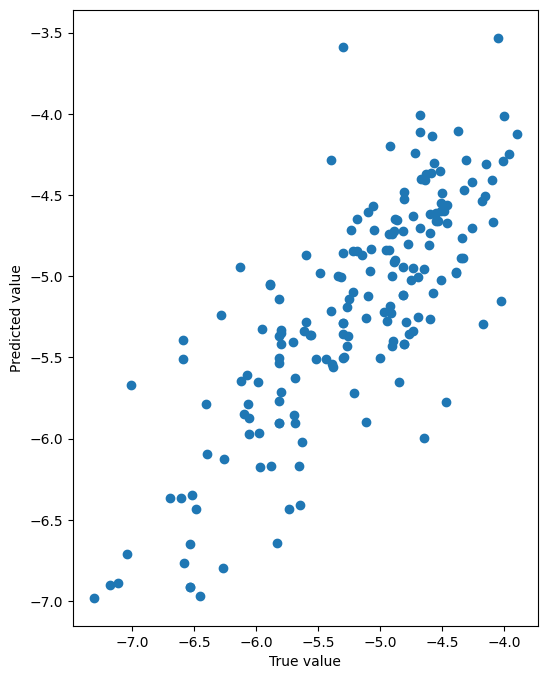

In [ ]:
plt.figure(figsize=(6,8))
plt.scatter(y_test, preds_test)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [ ]:
mse2 = mean_squared_error(preds_test, y_test)
mse2

0.22252788199351184

In [ ]:
# Let's try predicting using only the MolWt!

In [ ]:
len(X_train)

726

In [ ]:
X_2 = X_fea['MolWt']

In [ ]:
X_2

0      290.271
1      245.366
2      299.370
3      113.120
4      337.463
        ...   
905    172.268
906    330.292
907    703.880
908    719.836
909    281.352
Name: MolWt, Length: 910, dtype: float64

In [ ]:
y

0     -6.220000
1     -3.860000
2     -4.090000
3     -5.935409
4     -4.840000
         ...   
905   -4.680000
906   -4.950000
907   -5.080000
908   -5.300000
909   -4.840000
Name: Y, Length: 910, dtype: float64

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y,
                                                        random_state=234,
                                                        shuffle=True,
                                                        test_size=.2)

In [ ]:
X_train2

894    426.423
491    510.543
659    250.338
266    480.649
906    330.292
        ...   
161    252.347
863    304.254
697    186.295
324    349.137
456    113.547
Name: MolWt, Length: 728, dtype: float64

In [ ]:
y_train2

894   -4.710000
491   -4.699485
659   -4.880000
266   -5.690000
906   -4.950000
         ...   
161   -5.900000
863   -6.509319
697   -3.510000
324   -5.390000
456   -4.220202
Name: Y, Length: 728, dtype: float64

In [ ]:
lr3 = LinearRegression(copy_X=True,
                       fit_intercept=True)

In [ ]:
lr3.fit(X_train2.values.reshape(-1,1),y_train2)

LinearRegression()

In [ ]:
preds3 = lr3.predict(X_test2.values.reshape(-1,1))

In [ ]:
mse3 = mean_squared_error(preds3, y_test2)
mse3

0.5283465619723895

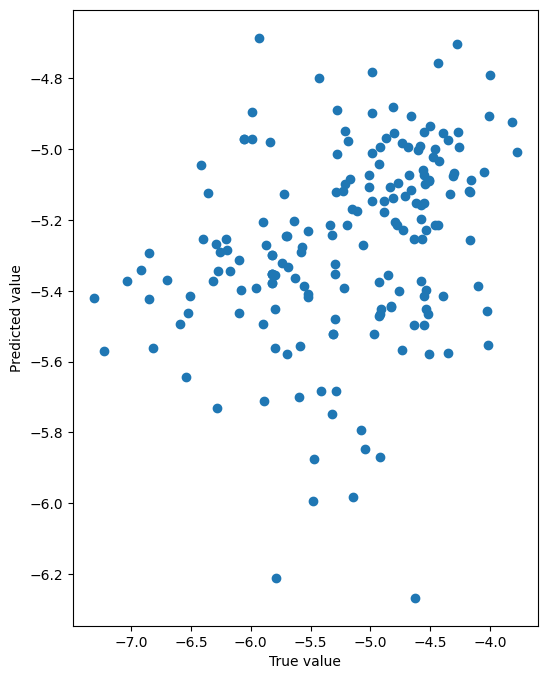

In [ ]:
plt.figure(figsize=(6,8))
plt.scatter(y_test2, preds3)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()